(0.24705073567249258,
 0.5487179487179488,
 0.0845172577785526,
 0.5487179487179488,
 0.3165019222324091,
 0.4597538997286296,
 0.5487179487179488)

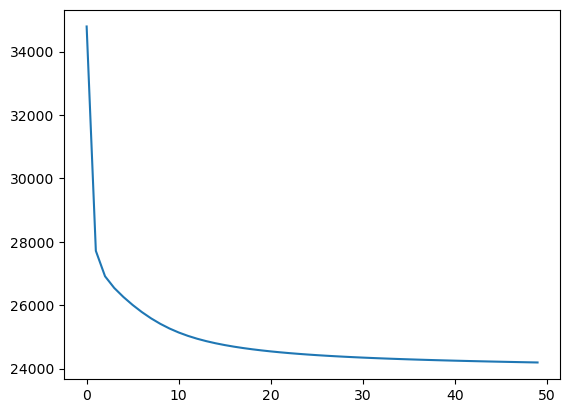

In [4]:
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from util import eval, loadDataset, normalization, kmeansInitialization

eps = torch.tensor(10 ** -10)

datasets = ['3Sources.npy',
'BBCSport.npy',
'Caltech101.npy',
'Caltech_2.npy',
'Citeseer.npy',
'Coil100.npy',
'Cora.npy',
'EYaleB10.npy',
'Handwritten.npy',
'MNIST10.npy',
'UCIdigit.npy',
'Umist.npy',
'Yale32.npy',
'Yeast.npy',
'Cora2.npy',
'texas.npy',
'wisconsin.npy',
'washington.npy',
'cornell.npy']


X0, Y, V, c = loadDataset(18)





r = c
k = 25
lam = 1
delta = 1
alpha = 0.8
iter = 50

W = []
H = []
X = []


for v in range(V):
    
    X.append(torch.tensor(X0[v]).type(torch.float32))
    
    d, n = X[v].shape

    W.append(torch.ones(d, r))
    
    #Initialization by Kmeans
    H.append(kmeansInitialization(X[v], r))

Hs = torch.mean(torch.stack(H), dim=0)

    
A = []
for v in range(V):
    
    A0 = kneighbors_graph(X[v].T, k, mode='connectivity', include_self=False).toarray()
    A0 = torch.tensor(A0).type(torch.float32)
    A0 = torch.maximum(A0, A0.T)

    A.append(A0)

Aopt = A[0]
for v in range(1,V):
    Aopt =  torch.minimum(Aopt, A[v])
    

Dopt = torch.diag(torch.sum(Aopt, dim = 1))
Lopt = Dopt - Aopt

    
# Optimization
err = torch.zeros(iter)

for t in range(iter):
    for v in range(V):
        
        # Updating Ws
        Wn = X[v]        @ H[v].T + X[v]      @ Hs.T
        Wd = W[v] @ H[v] @ H[v].T + W[v] @ Hs @ Hs.T
        W[v] = W[v] * (Wn / torch.maximum(Wd, eps)) ** 0.5
        # Normalization?
    
    # Updating H*
    Hn = torch.zeros(r, n)
    Hd = torch.zeros(r, n)
    Hsum = torch.zeros(r, n)
    for v in range(V):
        Hn += W[v].T @ X[v]
        Hd += W[v].T @ W[v] @ Hs
        
        Hsum += H[v]
        
    Hd += delta/2 * (Hsum/V) + Hs
        
    Hs = Hs * (Hn / torch.maximum(Hd, eps)) ** 0.5 
    
    # Normalization?
    
    Hsum = torch.zeros(r, n)
    for v in range(V):
       
        # Updating Hs
        Hn = W[v].T @ X[v]        + lam * (H[v] @ Aopt)
        Hd = W[v].T @ W[v] @ H[v] + lam * (H[v] @ Dopt) + H[v]
        H[v] = H[v] * (Hn / torch.maximum(Hd, eps)) ** 0.5
        
        Hsum += H[v]
        
        # Normalization?
        
        # Calculating cost function
        err[t] += torch.norm(X[v] - W[v] @ H[v]) ** 2 + torch.norm(X[v] - W[v] @ Hs) ** 2 \
        + lam * torch.trace(H[v] @ Lopt @ H[v].T) + delta * torch.trace(Hs.T @ (Hsum/V))
           
plt.plot(err)


Hfinal = torch.cat((alpha * Hs, (1 - alpha) * (Hsum/V)), 0)

pred = KMeans(n_clusters=c).fit(Hfinal.T).labels_

nmi, acc, ari, f1mi, f1ma, f1we, pur = eval(Y, pred)
nmi, acc, ari, f1mi, f1ma, f1we, pur